In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC


from src.data import generate_data, discretize_dataset, load_preprocesss_data
from src.feature_selection import CMIM, JMIM, IGFS, wrapper_criterion, l1_selection, find_relevant_features, evaluate_feature_selection, perform_feature_selection_on_all_datasets
from src.visualization import plot_results, plot_multiple_plots

In [2]:
data = load_preprocesss_data()

Finding relevant features for divorce dataset...
Calculations completed!
Finding relevant features for aids dataset...
Calculations completed!
Finding relevant features for lol dataset...
Calculations completed!
Finding relevant features for cancer dataset...
Calculations completed!
Finding relevant features for gait dataset...
Calculations completed!
Finding relevant features for generated_0 dataset...
Calculations completed!
Finding relevant features for generated_1 dataset...
Calculations completed!
Finding relevant features for generated_2 dataset...
Calculations completed!


Processing dataset generated_2: 100%|██████████| 6/6 [00:00<00:00, 21.43it/s]


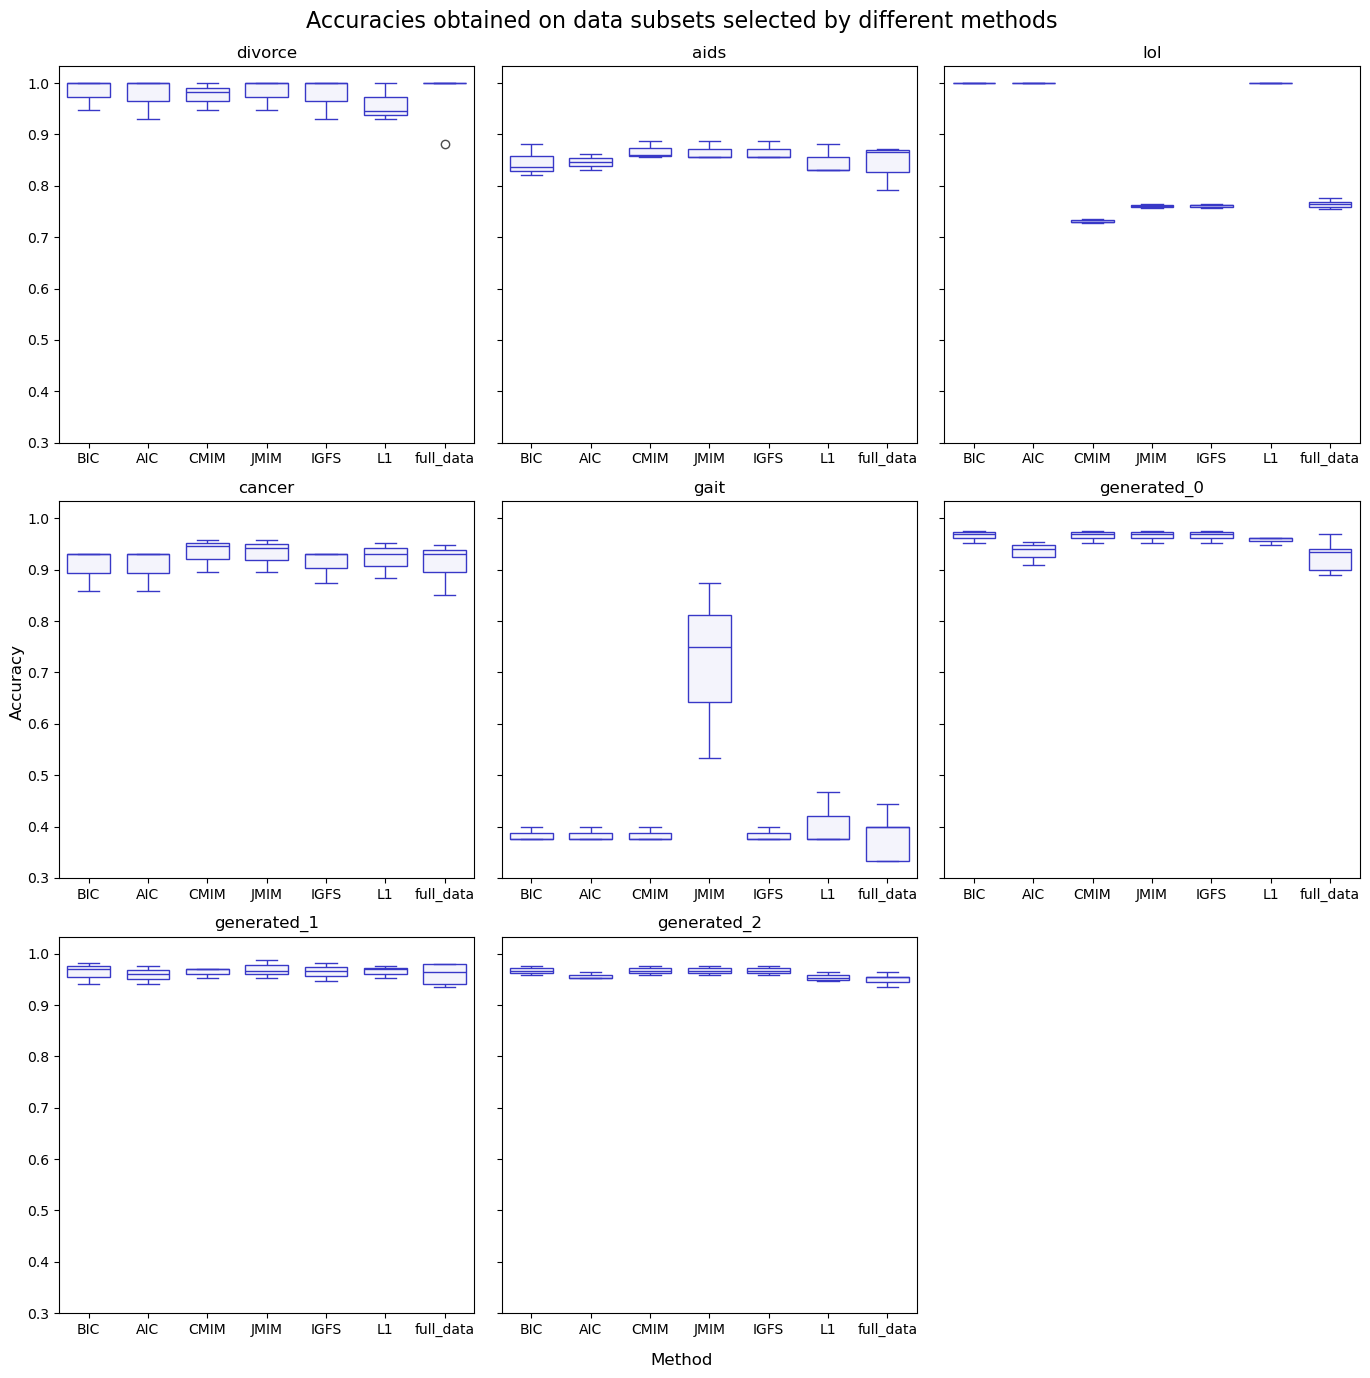

In [4]:
relevant_features = perform_feature_selection_on_all_datasets(data)
accuracy_scores = evaluate_feature_selection(data, relevant_features, SVC)
plot_multiple_plots(accuracy_scores)